In [1]:
import pandas as pd
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
style = "<style>svg{width:50% !important; height:10% !important;}<style>"
HTML(style)
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

Посмотрим на данные

In [ ]:
df = pd.read_csv("/car.csv")
df

,buying,maint,doors,persons,lug_boot,safety,C
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


Посмотрим на распределение целевой переменной

(array([1209.,    0.,  384.,    0.,   65.,    0.,   69.]),
 array([0.        , 0.42857143, 0.85714286, 1.28571429, 1.71428571,
        2.14285714, 2.57142857, 3.        ]),
 <BarContainer object of 7 artists>)

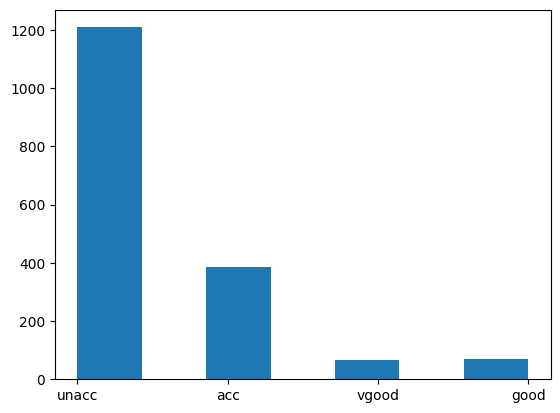

In [ ]:
plt.hist (df['C'], bins=7 )

Так как фичи категориальные, то применим one-hot encoding

In [ ]:
X = df.drop(['C'], axis = 1)
X = pd.get_dummies(X)
y = df.C
y = pd.get_dummies(y)

In [ ]:
X

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1723,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
1724,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0
1725,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1


In [ ]:
y

,acc,good,unacc,vgood
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1722,0,1,0,0
1723,0,0,0,1
1724,0,0,1,0
1725,0,1,0,0


Создадим моедль

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

Разделим датасет на тренировочную и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Обучим модель пока что без всяких подборов параметров

In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
clf.score(X_test, y_test)

0.9631578947368421

Далее наглядно посмотрим на работу модели

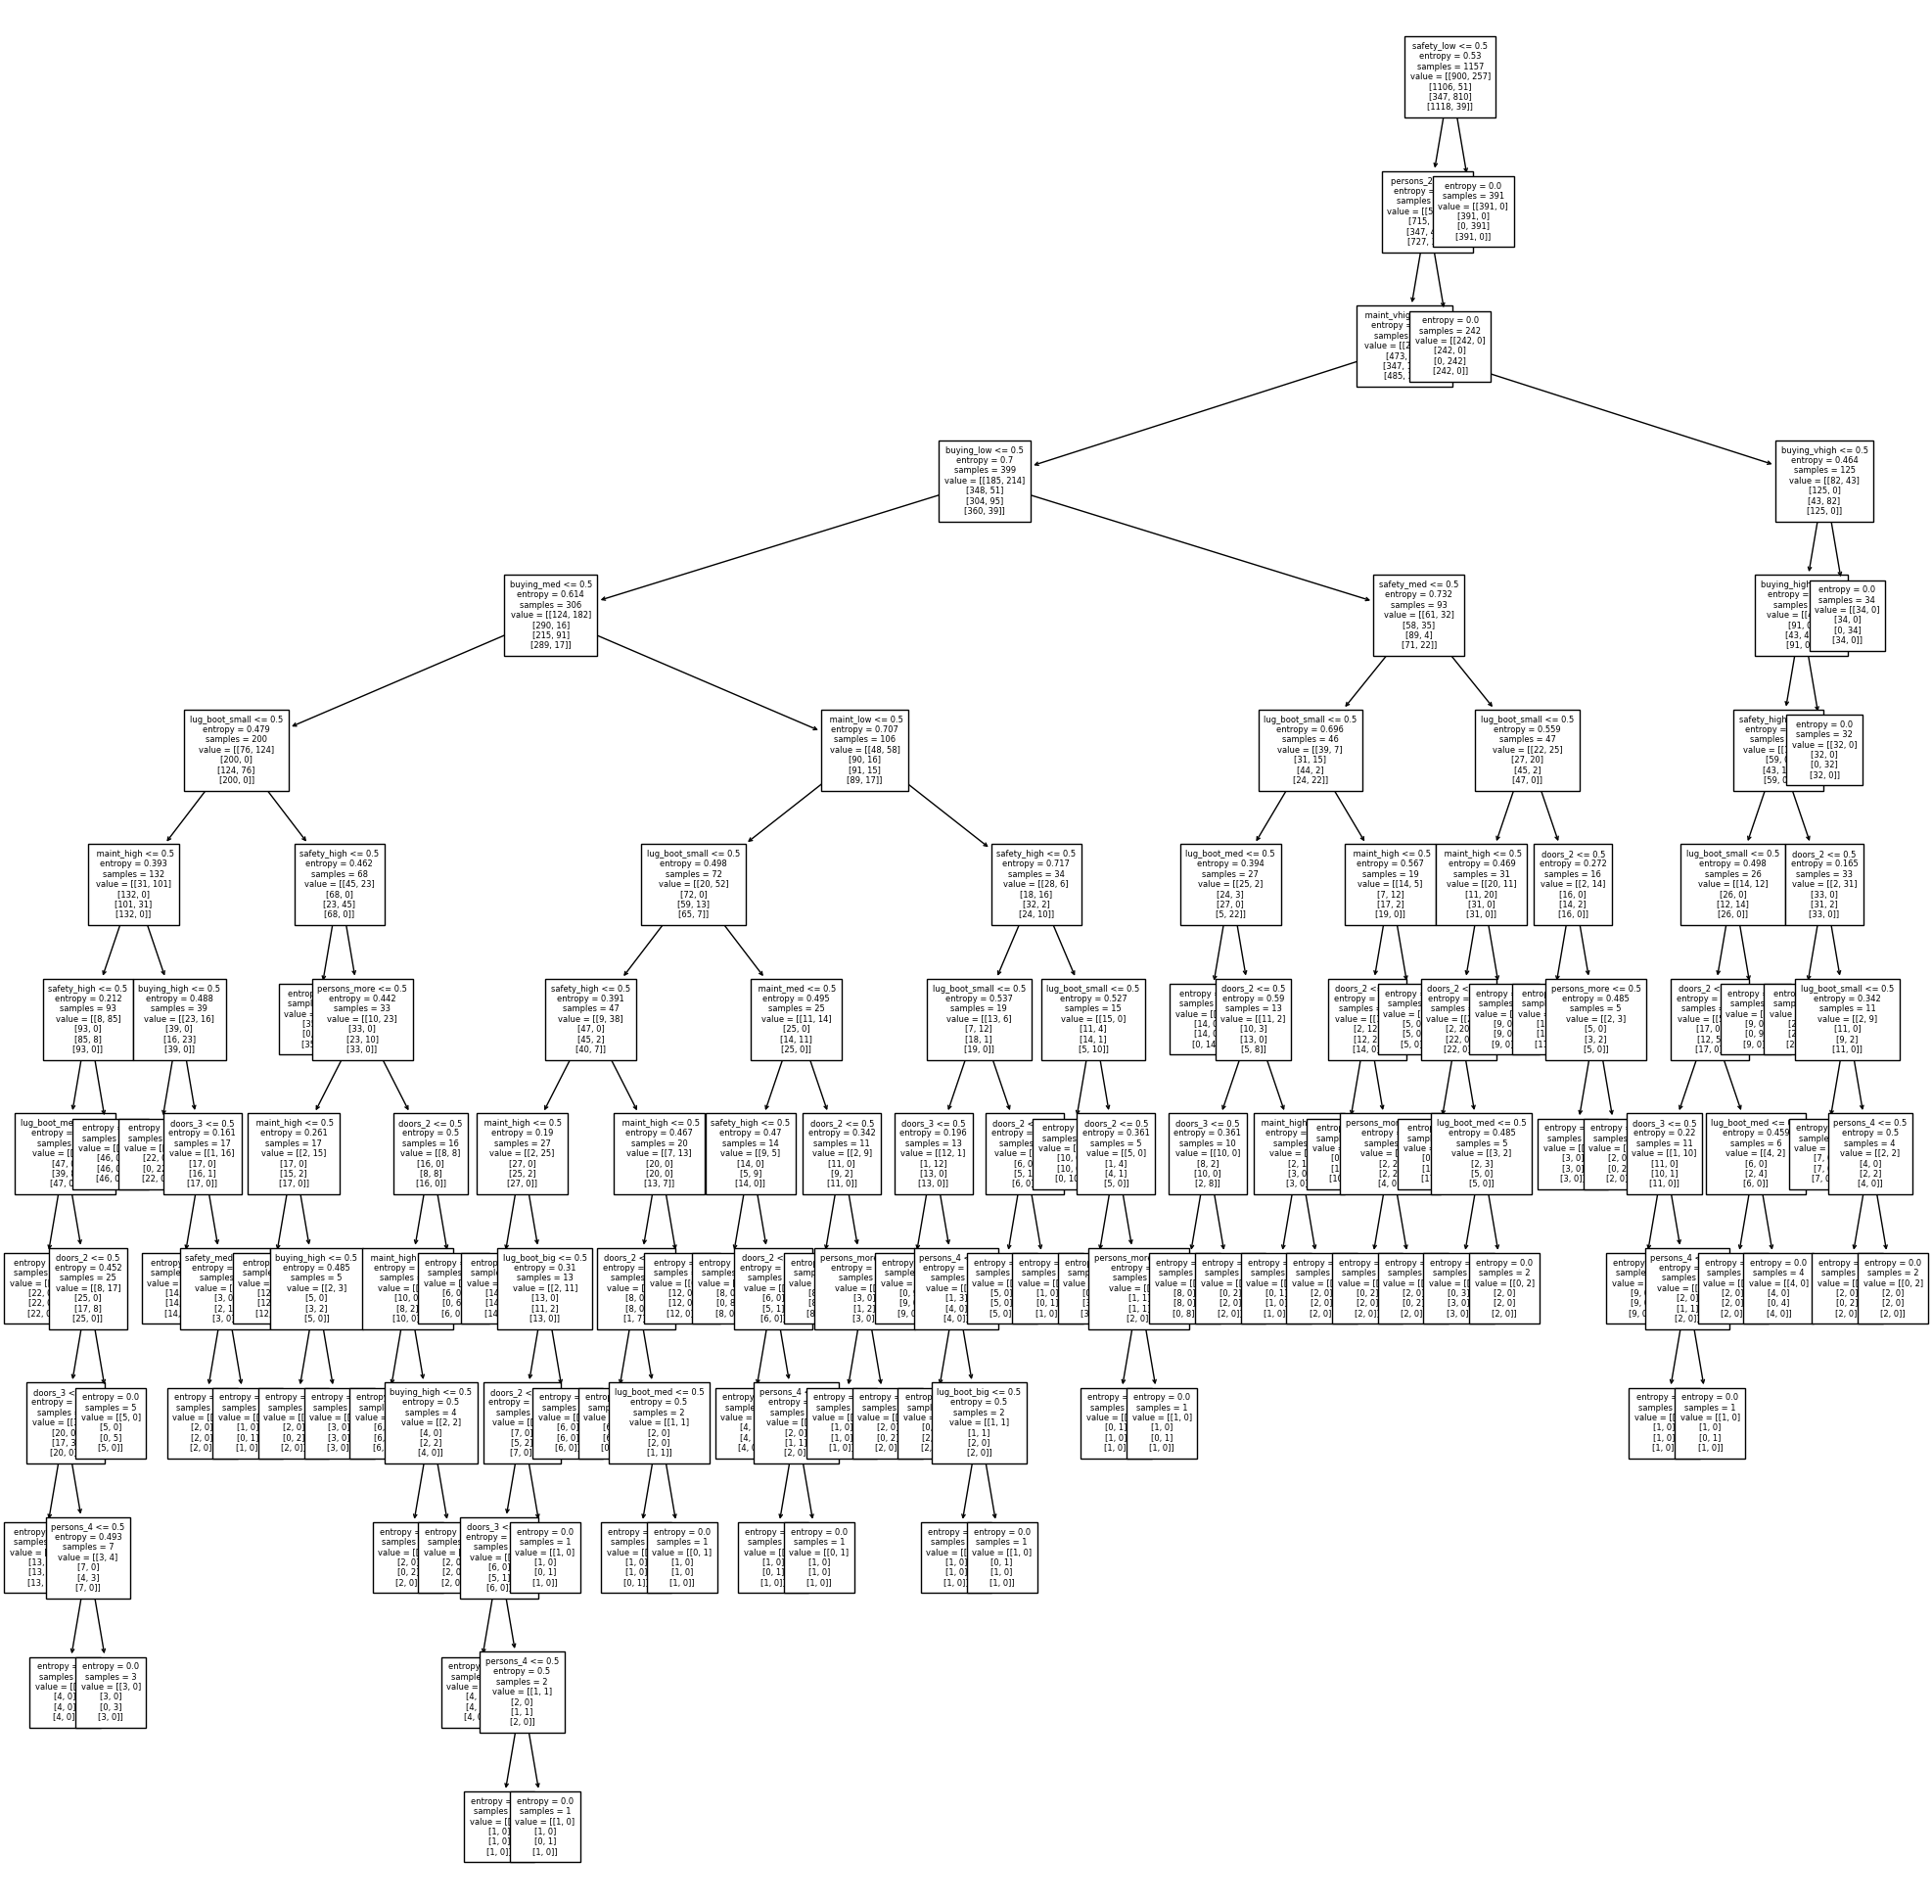

In [ ]:
plt.figure(figsize=(25,25))
tree.plot_tree(clf, feature_names=list(X),fontsize=6)
plt.savefig('tree_high_dpi', dpi=200)

Далее вручную попробуем найти наилучшую глубину дерева

In [ ]:
max_depth_val = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_val:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv = 5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

In [ ]:
scores_data

,max_depth,train_score,test_score,cross_val_score
0,1,0.700086,0.700000,0.700060
0,2,0.547105,0.571930,0.547074
0,3,0.802939,0.810526,0.776164
0,4,0.775281,0.773684,0.760572
0,5,0.820225,0.842105,0.838327
...,...,...,...,...
0,95,1.000000,0.959649,0.957665
0,96,1.000000,0.959649,0.955079
0,97,1.000000,0.959649,0.961114
0,98,1.000000,0.959649,0.960263


In [ ]:
best_d = scores_data[scores_data['cross_val_score'] == scores_data['cross_val_score'].max()]
best_depth = best_d['max_depth']
best_depth[0]

24

Теперь обучим модель с найденной глубтной (параметром)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth[0])
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9631578947368421

Теперь разобьем наш датасет снова, но теперь выполним стратификацию по целевой переменной и посмортим на ее результат обучения


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9736842105263158

ОПять вручную найдем параметр

In [ ]:
max_depth_val = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_val:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv = 5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

In [ ]:
best_d = scores_data[scores_data['cross_val_score'] == scores_data['cross_val_score'].max()]
best_depth = best_d['max_depth']
best_depth[0]

48

Обучаем с найденным параметром 

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth[0])
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9736842105263158

Теперь поиск оптимальных параметров предоставим GridSearch и валидации

In [ ]:
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 100)}
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=48),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 100)})

In [ ]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 16}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_

Итог по дереву решений

In [ ]:
best_clf.score(X_test, y_test)

0.9719298245614035

Теперь поработаем с деревом решений
Сначала не будем балансировать данные

In [ ]:
clf_rf = RandomForestClassifier()
parametrs ={'n_estimators': [i for i in range(10, 101, 10)], 'max_depth': [i for i in range(10, 100)]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test,y_test)

0.9385964912280702

In [ ]:
best_clf

RandomForestClassifier(max_depth=19, n_estimators=60)

А теперь сбалансируем


In [ ]:
clf_rf = RandomForestClassifier(class_weight='balanced')
parametrs ={'n_estimators': [i for i in range(10, 101, 10)], 'max_depth': [i for i in range(10, 100)]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test,y_test)

0.9666666666666667

In [ ]:
grid_search_cv_clf.best_params_

{'max_depth': 10, 'n_estimators': 100}